In [1]:
import pandas as pd
import numpy as np
import json
import pickle

from surprise import Reader, Dataset
from surprise.prediction_algorithms import SVD

from nltk.corpus import stopwords
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import RegexpTokenizer

import re
import string
import random
from PIL import Image
import requests
from io import BytesIO
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
df = pd.read_pickle('interact')

Bring in a dataset for book infomation

In [3]:
df_book = pd.read_pickle('book_info')

In [4]:
df_book.sample(5)

,book_id,title,popular_shelves,description,authors,average_rating,ratings_count,url,image_url
87406,18164616,Mastic,"[{'count': '34', 'name': 'to-read'}, {'count':...",When the body of supermodel Harmony Phelps tur...,"[{'author_id': '6901568', 'role': ''}]",4.55,8,https://www.goodreads.com/book/show/18164616-m...,https://images.gr-assets.com/books/1380749920m...
193242,13562181,Tredan's Bane,"[{'count': '31', 'name': 'to-read'}, {'count':...",A magician's ghost warns Lanith about fire and...,"[{'author_id': '5409092', 'role': ''}]",4.26,4,https://www.goodreads.com/book/show/13562181-t...,https://images.gr-assets.com/books/1332808826m...
74218,15798168,"Fairy Tail, Vol. 24 (Fairy Tail, #24)","[{'count': '504', 'name': 'to-read'}, {'count'...",PREMONITIONS AND PROMOTIONS\nNatsu and gang re...,"[{'author_id': '150810', 'role': ''}]",4.45,166,https://www.goodreads.com/book/show/15798168-f...,https://s.gr-assets.com/assets/nophoto/book/11...
178113,2132220,"Harry Potter Audio Collection (Harry Potter, #...","[{'count': '5605', 'name': 'favorites'}, {'cou...",Enjoy the complete Harry Potter series perform...,"[{'author_id': '1077326', 'role': ''}, {'autho...",4.74,245,https://www.goodreads.com/book/show/2132220.Ha...,https://s.gr-assets.com/assets/nophoto/book/11...
247190,13619474,Last Apprentice (The Last Apprentice / Wardsto...,"[{'count': '1762', 'name': 'to-read'}, {'count...",Warning: Not to be listened to after dark\nCap...,"[{'author_id': '146374', 'role': ''}, {'author...",3.97,8,https://www.goodreads.com/book/show/13619474-l...,https://images.gr-assets.com/books/1355132586m...


In [5]:
df.sample(5)

,user_id_num,book_id,rating
11451,315,106,3
3812,614,13466202,3
9129,869,12588363,5
24658,744,12973964,4
28553,575,259836,4


In [6]:
idx = list(set(df['book_id']))

In [7]:
library = df_book[df_book['book_id'].isin(idx)]
library

,book_id,title,popular_shelves,description,authors,average_rating,ratings_count,url,image_url
9,780918,"Rite of Conquest (William the Conqueror, #1)","[{'count': '145', 'name': 'to-read'}, {'count'...",,"[{'author_id': '41194', 'role': ''}]",3.43,148,https://www.goodreads.com/book/show/780918.Rit...,https://images.gr-assets.com/books/1309203943m...
42,18663972,"Fortune's Pawn (Paradox, #1)","[{'count': '12597', 'name': 'to-read'}, {'coun...",When professional mercenary Deviana Morris too...,"[{'author_id': '6572837', 'role': ''}]",3.96,1023,https://www.goodreads.com/book/show/18663972-f...,https://s.gr-assets.com/assets/nophoto/book/11...
44,9402756,The Shadow Queen (The Black Jewels #7),"[{'count': '3501', 'name': 'to-read'}, {'count...",The national bestselling Black Jewels saga con...,"[{'author_id': '26897', 'role': ''}]",4.29,19,https://www.goodreads.com/book/show/9402756-th...,https://images.gr-assets.com/books/1297875072m...
47,10806008,Peter Nimble and His Fantastic Eyes (Peter Nim...,"[{'count': '10607', 'name': 'to-read'}, {'coun...",Peter Nimble and His Fantastic Eyesis the utte...,"[{'author_id': '4722094', 'role': ''}]",4.04,6049,https://www.goodreads.com/book/show/10806008-p...,https://images.gr-assets.com/books/1353594747m...
55,11731782,"Collide (Collide, #1)","[{'count': '6001', 'name': 'to-read'}, {'count...",Sherry has always known there was something ou...,"[{'author_id': '4951964', 'role': ''}]",3.86,5125,https://www.goodreads.com/book/show/11731782-c...,https://images.gr-assets.com/books/1352764436m...
...,...,...,...,...,...,...,...,...,...
258543,279665,"Brave the Betrayal (Everworld, #8)","[{'count': '622', 'name': 'to-read'}, {'count'...","David, Christopher, Jalil and April have a new...","[{'author_id': '1036736', 'role': ''}]",3.90,1767,https://www.goodreads.com/book/show/279665.Bra...,https://images.gr-assets.com/books/1322353274m...
258544,279666,"Entertain the End (Everworld, #12)","[{'count': '691', 'name': 'to-read'}, {'count'...",There is a place that shouldn't exist. But doe...,"[{'author_id': '1036736', 'role': ''}]",3.89,1607,https://www.goodreads.com/book/show/279666.Ent...,https://images.gr-assets.com/books/1375603617m...
258545,279667,"Mystify the Magician (Everworld, #11)","[{'count': '670', 'name': 'to-read'}, {'count'...",There is a place that shouldn't exist. But doe...,"[{'author_id': '1036736', 'role': ''}]",3.98,1586,https://www.goodreads.com/book/show/279667.Mys...,https://images.gr-assets.com/books/1375603595m...
258549,57064,"Hammerfall (The Gene Wars, #1)","[{'count': '22', 'name': 'to-read'}, {'count':...",One of the most renowned figures in science fi...,"[{'author_id': '989968', 'role': ''}]",3.62,1143,https://www.goodreads.com/book/show/57064.Hamm...,https://s.gr-assets.com/assets/nophoto/book/11...


In [50]:
random_lib = library[library.ratings_count> 100000].sort_values(by='average_rating', ascending=False).head(20)

In [51]:
needed_col1 = ['book_id','title','average_rating', 'image_url'] 

In [52]:
ran_app = random_lib[needed_col1]

In [53]:
filename = 'random_app'
outfile = open(filename,'wb')
pickle.dump(ran_app,outfile)
outfile.close()

In [41]:
needed_col = ['book_id','title','image_url'] 

In [42]:
lib_app = library[needed_col]
lib_app 

,book_id,title,image_url
9,780918,"Rite of Conquest (William the Conqueror, #1)",https://images.gr-assets.com/books/1309203943m...
42,18663972,"Fortune's Pawn (Paradox, #1)",https://s.gr-assets.com/assets/nophoto/book/11...
44,9402756,The Shadow Queen (The Black Jewels #7),https://images.gr-assets.com/books/1297875072m...
47,10806008,Peter Nimble and His Fantastic Eyes (Peter Nim...,https://images.gr-assets.com/books/1353594747m...
55,11731782,"Collide (Collide, #1)",https://images.gr-assets.com/books/1352764436m...
...,...,...,...
258543,279665,"Brave the Betrayal (Everworld, #8)",https://images.gr-assets.com/books/1322353274m...
258544,279666,"Entertain the End (Everworld, #12)",https://images.gr-assets.com/books/1375603617m...
258545,279667,"Mystify the Magician (Everworld, #11)",https://images.gr-assets.com/books/1375603595m...
258549,57064,"Hammerfall (The Gene Wars, #1)",https://s.gr-assets.com/assets/nophoto/book/11...


In [57]:
lib_app.loc[9]['book_id'].dtype

dtype('int64')

In [43]:
filename = 'lib_app'
outfile = open(filename,'wb')
pickle.dump(lib_app,outfile)
outfile.close()

## Create User input

In [8]:
def book_rater(library, num):
    userID = 10000
    book_list = []
    while num > 0:
        book = library.sample(1)
        print('Book Title: ', book['title'].values[0])
        print('Average Rating from Users: ', book['average_rating'].values[0])
        print('-' * 50)
        
        rating = input('Have you read the book?\n If so, how do you rate this book (on scale 1-5)?\n If not, please type \"n\"\n')
        
        if rating == 'n':
            continue
        else:
            rating_abook = {'user_id_num':userID, 'book_id':book['book_id'].values[0],'rating':int(rating)}
            if rating_abook['rating'] < 1:
                rating_abook['rating'] = 1
            if rating_abook['rating'] > 5:
                rating_abook['rating'] = 5
            book_list.append(rating_abook) 
            num -= 1
            print('-' * 50)
    return book_list

In [9]:
user_rating = book_rater(library, 8)

Book Title:  Kissing Sin (Riley Jenson Guardian #2)
Average Rating from Users:  4.07
--------------------------------------------------
Have you read the book?
 If so, how do you rate this book (on scale 1-5)?
 If not, please type "n"
3
--------------------------------------------------
Book Title:  The Hanging Tree (Peter Grant, #6)
Average Rating from Users:  4.22
--------------------------------------------------
Have you read the book?
 If so, how do you rate this book (on scale 1-5)?
 If not, please type "n"
2
--------------------------------------------------
Book Title:  Eternally Yours
Average Rating from Users:  3.71
--------------------------------------------------
Have you read the book?
 If so, how do you rate this book (on scale 1-5)?
 If not, please type "n"
4
--------------------------------------------------
Book Title:  The Twilight Saga (Twilight, #1-4)
Average Rating from Users:  3.88
--------------------------------------------------
Have you read the book?
 If so,

In [10]:
user_rating

[{'user_id_num': 10000, 'book_id': 74043, 'rating': 3},
 {'user_id_num': 10000, 'book_id': 25938442, 'rating': 2},
 {'user_id_num': 10000, 'book_id': 18872831, 'rating': 4},
 {'user_id_num': 10000, 'book_id': 3090465, 'rating': 5},
 {'user_id_num': 10000, 'book_id': 17378508, 'rating': 4},
 {'user_id_num': 10000, 'book_id': 3586934, 'rating': 3},
 {'user_id_num': 10000, 'book_id': 7775569, 'rating': 1},
 {'user_id_num': 10000, 'book_id': 21839516, 'rating': 2}]

## Making Prediction With the New Ratings

In [11]:
reader = Reader()

In [12]:
new_df = df.append(user_rating, ignore_index=True)
new_data = Dataset.load_from_df(new_df, reader)

In [13]:
svd_final_model = SVD(n_factors= 20, reg_all=0.02)
svd_final_model.fit(new_data.build_full_trainset())

In [14]:
list_of_books = []
for m_id in new_df['book_id'].unique():
    list_of_books.append( (m_id,svd_final_model.predict(10000,m_id)[3]))

In [15]:
list_of_books

[(29056083, 3.0904800555525127),
 (33266253, 3.5413684368764717),
 (667488, 3.452503908154457),
 (820343, 3.8345531089421354),
 (23734628, 3.4940356653619458),
 (6068551, 3.1095716334518344),
 (353016, 3.3710697424887432),
 (15745371, 3.7179751724575634),
 (12603860, 3.4219932815514427),
 (13076222, 3.4073511047329816),
 (12751687, 3.362802235705886),
 (10637766, 3.4036985738204053),
 (7263429, 3.461314906406829),
 (15861491, 3.37553806128004),
 (7171637, 3.694665085814266),
 (187811, 3.7472261378645015),
 (10429045, 3.4751352461248555),
 (7124101, 3.2076951404001006),
 (8130839, 3.264096873445885),
 (10314229, 3.3602978681981317),
 (5266655, 3.0932043737933204),
 (100915, 3.58258626653652),
 (6583427, 3.4085504930239376),
 (6763961, 3.3524761451603196),
 (7476122, 3.4576947939092015),
 (11443325, 3.184440116184092),
 (8428064, 3.646550590932302),
 (11454587, 3.3120311378818363),
 (8487363, 3.5095567848555347),
 (8803932, 3.6091076960638424),
 (11418574, 3.5052914474623447),
 (13508069

In [16]:
ranked_books = sorted(list_of_books, key=lambda x:x[1], reverse=True)

### Get Titles of Recommended Books Function

In [17]:
def recommended_books(user_ratings, book_title_df, n):
        rec_list = []
        for idx, rec in enumerate(user_ratings):
            title = book_title_df.loc[book_title_df['book_id'] == int(rec[0])]
            print('Recommendation #', idx+1, ': ', title['title'].values[0], '\n')
            rec_list.append(title['book_id'].values[0])
            n -= 1
            
            i = title['image_url'].values[0]
            response = requests.get(i)
            img = Image.open(BytesIO(response.content))
            plt.figure()
            print(plt.imshow(img))
            
            if n == 0:
                return rec_list

Recommendation # 1 :  The Name of the Wind (The Kingkiller Chronicle, #1) 

AxesImage(54,36;334.8x217.44)
Recommendation # 2 :  A Monster Calls 

AxesImage(54,36;334.8x217.44)
Recommendation # 3 :  Queen of the Darkness (The Black Jewels, #3) 

AxesImage(54,36;334.8x217.44)
Recommendation # 4 :  The Wise Man's Fear (The Kingkiller Chronicle, #2) 

AxesImage(54,36;334.8x217.44)
Recommendation # 5 :  Harry Potter and the Half-Blood Prince (Harry Potter, #6) 

AxesImage(54,36;334.8x217.44)
Recommendation # 6 :  Words of Radiance (The Stormlight Archive, #2) 

AxesImage(54,36;334.8x217.44)
Recommendation # 7 :  Harry Potter Boxset (Harry Potter, #1-7) 

AxesImage(54,36;334.8x217.44)
Recommendation # 8 :  The Way of Kings (The Stormlight Archive, #1) 

AxesImage(54,36;334.8x217.44)
Recommendation # 9 :  Harry Potter and the Deathly Hallows (Harry Potter, #7) 

AxesImage(54,36;334.8x217.44)
Recommendation # 10 :  The Return of the King (The Lord of the Rings, #3) 

AxesImage(54,36;334.8x217.

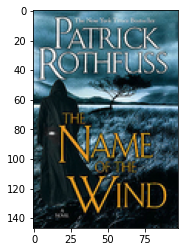

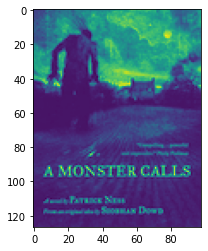

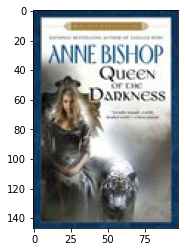

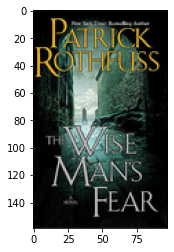

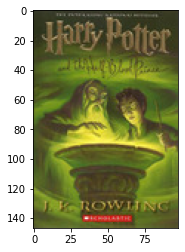

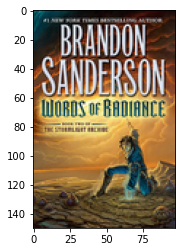

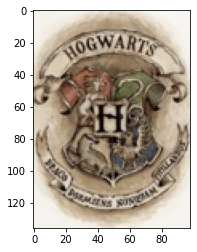

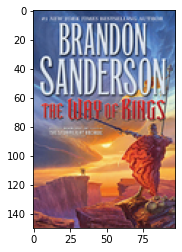

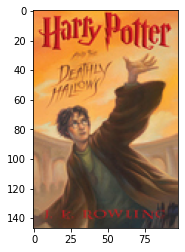

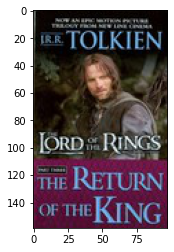

In [18]:
rec_idx = recommended_books(ranked_books, library, 10)

# Build Comics Recommendation based of Book Description

### Import necessary datasets 

In [19]:
df_comics = pd.read_json('data/goodreads_books_comics_graphic.json', lines=True)

In [20]:
df_comics.sample(5)

,isbn,text_reviews_count,series,country_code,language_code,popular_shelves,asin,is_ebook,average_rating,kindle_asin,...,publication_month,edition_information,publication_year,url,image_url,book_id,ratings_count,work_id,title,title_without_series
66859,142780513X,5,[230571],US,,"[{'count': '67', 'name': 'manga'}, {'count': '...",,false,4.35,,...,,,,https://www.goodreads.com/book/show/3418229-ar...,https://s.gr-assets.com/assets/nophoto/book/11...,3418229,178,3458678,"Aria, Volume 4 (Aria, #4)","Aria, Volume 4 (Aria, #4)"
38957,0974596191,1,[688770],US,,"[{'count': '21', 'name': 'to-read'}, {'count':...",,false,3.75,,...,8,,2004,https://www.goodreads.com/book/show/29098.The_...,https://s.gr-assets.com/assets/nophoto/book/11...,29098,24,29569,The Collection 2,The Collection 2
57490,159532836X,15,[224949],US,eng,"[{'count': '172', 'name': 'manga'}, {'count': ...",,false,4.28,,...,,,,https://www.goodreads.com/book/show/32301.Blam...,https://s.gr-assets.com/assets/nophoto/book/11...,32301,739,32493,"Blame!, Vol. 3","Blame!, Vol. 3"
13435,9788498470,7,[337704],US,spa,"[{'count': '49282', 'name': 'to-read'}, {'coun...",,false,4.36,,...,9,Edicion Integral,2010,https://www.goodreads.com/book/show/32320259-p...,https://images.gr-assets.com/books/1475255631m...,32320259,27,13344769,Persépolis,Persépolis
60300,,3,[],US,,"[{'count': '9', 'name': 'comics'}, {'count': '...",B072WLL5YV,true,3.03,B072WLL5YV,...,,,,https://www.goodreads.com/book/show/35864058-w...,https://s.gr-assets.com/assets/nophoto/book/11...,35864058,9,56941884,Wonder Woman (2016-) #29,Wonder Woman (2016-) #29


In [21]:
df_comics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89411 entries, 0 to 89410
Data columns (total 29 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   isbn                  89411 non-null  object 
 1   text_reviews_count    89411 non-null  int64  
 2   series                89411 non-null  object 
 3   country_code          89411 non-null  object 
 4   language_code         89411 non-null  object 
 5   popular_shelves       89411 non-null  object 
 6   asin                  89411 non-null  object 
 7   is_ebook              89411 non-null  object 
 8   average_rating        89411 non-null  float64
 9   kindle_asin           89411 non-null  object 
 10  similar_books         89411 non-null  object 
 11  description           89411 non-null  object 
 12  format                89411 non-null  object 
 13  link                  89411 non-null  object 
 14  authors               89411 non-null  object 
 15  publisher          

**Use only english language comics**

In [22]:
df_comics.description.sample(1)

82762    Recopilatorio de chistes con tematica medica.
Name: description, dtype: object

In [23]:
df_comics = df_comics[df_comics.language_code == 'eng']

### create a dataframe from recommended book index

In [24]:
rec_book_df = library[library['book_id'].isin(rec_idx)]
rec_book_df 

,book_id,title,popular_shelves,description,authors,average_rating,ratings_count,url,image_url
660,186074,The Name of the Wind (The Kingkiller Chronicle...,"[{'count': '296158', 'name': 'to-read'}, {'cou...","Told in Kvothe's own voice, this is the tale o...","[{'author_id': '108424', 'role': ''}]",4.55,416634,https://www.goodreads.com/book/show/186074.The...,https://images.gr-assets.com/books/1472068073m...
16001,8621462,A Monster Calls,"[{'count': '5576', 'name': 'favorites'}, {'cou...","An unflinching, darkly funny, and deeply movin...","[{'author_id': '370361', 'role': ''}, {'author...",4.37,110050,https://www.goodreads.com/book/show/8621462-a-...,https://images.gr-assets.com/books/1485991317m...
41331,7235533,"The Way of Kings (The Stormlight Archive, #1)","[{'count': '122397', 'name': 'to-read'}, {'cou...","Speak again the ancient oaths,\nLife before de...","[{'author_id': '38550', 'role': ''}]",4.64,151473,https://www.goodreads.com/book/show/7235533-th...,https://images.gr-assets.com/books/1507307887m...
42064,17332218,"Words of Radiance (The Stormlight Archive, #2)","[{'count': '34035', 'name': 'to-read'}, {'coun...",From #1 New York Times bestselling author Bran...,"[{'author_id': '38550', 'role': ''}]",4.77,78319,https://www.goodreads.com/book/show/17332218-w...,https://images.gr-assets.com/books/1507307927m...
73267,862041,"Harry Potter Boxset (Harry Potter, #1-7)","[{'count': '5605', 'name': 'favorites'}, {'cou...","The exciting tales of Harry Potter, the young ...","[{'author_id': '1077326', 'role': ''}]",4.74,193057,https://www.goodreads.com/book/show/862041.Har...,https://images.gr-assets.com/books/1392579059m...
75367,1215032,"The Wise Man's Fear (The Kingkiller Chronicle,...","[{'count': '80702', 'name': 'to-read'}, {'coun...","""There are three things all wise men fear: the...","[{'author_id': '108424', 'role': ''}]",4.57,253462,https://www.goodreads.com/book/show/1215032.Th...,https://images.gr-assets.com/books/1452624392m...
94272,1,Harry Potter and the Half-Blood Prince (Harry ...,"[{'count': '173909', 'name': 'to-read'}, {'cou...",The war against Voldemort is not going well: e...,"[{'author_id': '1077326', 'role': ''}, {'autho...",4.54,1713866,https://www.goodreads.com/book/show/1.Harry_Po...,https://images.gr-assets.com/books/1361039191m...
178868,136251,Harry Potter and the Deathly Hallows (Harry Po...,"[{'count': '41577', 'name': 'favorites'}, {'co...","It's no longer safe for Harry at Hogwarts, so ...","[{'author_id': '1077326', 'role': ''}, {'autho...",4.62,1784684,https://www.goodreads.com/book/show/136251.Har...,https://images.gr-assets.com/books/1474171184m...
191424,47959,"Queen of the Darkness (The Black Jewels, #3)","[{'count': '1755', 'name': 'fantasy'}, {'count...",Jaenelle Angelline now reigns as Queen-protect...,"[{'author_id': '26897', 'role': ''}]",4.37,20000,https://www.goodreads.com/book/show/47959.Quee...,https://images.gr-assets.com/books/1325423531m...
217434,18512,"The Return of the King (The Lord of the Rings,...","[{'count': '120844', 'name': 'to-read'}, {'cou...",The Companions of the Ring have become involve...,"[{'author_id': '656983', 'role': ''}]",4.51,473101,https://www.goodreads.com/book/show/18512.The_...,https://images.gr-assets.com/books/1389977161m...


## Text Preprocession 

In [25]:
# Function for removing NonAscii characters
def _removeNonAscii(s):
    return "".join(i for i in s if  ord(i)<128)
# Function for converting into lower case
def make_lower_case(text):
    return text.lower()
# Function for removing stop words
def remove_stop_words(text):
    text = text.split()
    stops = set(stopwords.words("english"))
    text = [w for w in text if not w in stops]
    text = " ".join(text)
    return text
# Function for removing punctuation
def remove_punctuation(text):
    tokenizer = RegexpTokenizer(r'\w+')
    text = tokenizer.tokenize(text)
    text = " ".join(text)
    return text
#Function for removing the html tags
def remove_html(text):
    html_pattern = re.compile('<.*?>')
    return html_pattern.sub(r'', text)

### Cleaning book and comics description 

In [26]:
rec_book_df['cleaned_des'] = rec_book_df['description'].apply(_removeNonAscii)
rec_book_df['cleaned_des'] = rec_book_df['cleaned_des'].apply(func = make_lower_case)
rec_book_df['cleaned_des'] = rec_book_df['cleaned_des'].apply(func = remove_stop_words)
rec_book_df['cleaned_des'] = rec_book_df['cleaned_des'].apply(func = remove_punctuation) 
rec_book_df['cleaned_des'] = rec_book_df['cleaned_des'].apply(func = remove_html)

<ipython-input-26-75105bb5f139>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rec_book_df['cleaned_des'] = rec_book_df['description'].apply(_removeNonAscii)
<ipython-input-26-75105bb5f139>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rec_book_df['cleaned_des'] = rec_book_df['cleaned_des'].apply(func = make_lower_case)
<ipython-input-26-75105bb5f139>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

In [27]:
df_comics['cleaned_des'] = df_comics['description'].apply(_removeNonAscii)
df_comics['cleaned_des'] = df_comics['cleaned_des'].apply(func = make_lower_case)
df_comics['cleaned_des'] = df_comics['cleaned_des'].apply(func = remove_stop_words)
df_comics['cleaned_des'] = df_comics['cleaned_des'].apply(func = remove_punctuation) 
df_comics['cleaned_des'] = df_comics['cleaned_des'].apply(func = remove_html)

In [28]:
filename = 'comics_cleaned_description'
outfile = open(filename,'wb')
pickle.dump(df_comics,outfile)
outfile.close()

### Converting the book description into vectors using minigram or bigram

In [29]:
tf = TfidfVectorizer(analyzer='word', ngram_range=(1, 2), min_df = 1, stop_words='english')

In [30]:
tfidf_matrix = tf.fit_transform(rec_book_df['cleaned_des'])

In [31]:
comics_matrix = tf.transform(df_comics['cleaned_des'])

### Calculating the similarity measures based on Cosine Similarity

In [32]:
cos_sim = cosine_similarity(comics_matrix, tfidf_matrix)

In [33]:
cos_sim_df = pd.DataFrame(cos_sim, index=df_comics['book_id'] , columns=rec_book_df['book_id'])

In [34]:
cos_sim_df

book_id,186074,8621462,7235533,17332218,862041,1215032,1,136251,47959,18512
book_id,,,,,,,,,,
13571772,0.000000,0.038376,0.014404,0.081746,0.009532,0.036104,0.000000,0.026967,0.000000,0.000000
35452242,0.043962,0.036402,0.085453,0.098507,0.013071,0.076993,0.061600,0.047425,0.000000,0.032759
27036536,0.032259,0.026733,0.117152,0.096944,0.035862,0.052855,0.060118,0.132010,0.038903,0.046223
11827783,0.027642,0.000000,0.064335,0.028282,0.021532,0.024003,0.018785,0.139148,0.029549,0.026886
12349665,0.070990,0.024954,0.047455,0.044655,0.045814,0.078336,0.029790,0.068781,0.017822,0.041827
...,...,...,...,...,...,...,...,...,...,...
6419558,0.078273,0.095447,0.013910,0.000000,0.025063,0.067203,0.020667,0.020101,0.012442,0.023499
32598998,0.057287,0.000000,0.000000,0.000000,0.000000,0.053490,0.030251,0.000000,0.000000,0.000000
10644600,0.030221,0.103221,0.014540,0.072129,0.049797,0.074789,0.012817,0.086947,0.000000,0.020030


In [35]:
cos_sim_df.describe()

book_id,186074,8621462,7235533,17332218,862041,1215032,1,136251,47959,18512
count,29520.000000,29520.000000,29520.000000,29520.000000,29520.000000,29520.000000,29520.000000,29520.000000,29520.000000,29520.000000
mean,0.032669,0.022084,0.019555,0.032594,0.019161,0.038449,0.028108,0.040802,0.016918,0.024668
std,0.033957,0.030294,0.026511,0.031693,0.022790,0.042353,0.026894,0.036140,0.024281,0.026005
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.026349,0.010549,0.009984,0.026741,0.014010,0.027603,0.024237,0.036274,0.000000,0.019418
75%,0.054307,0.034588,0.030027,0.051670,0.029858,0.053768,0.045359,0.063684,0.029082,0.040645
max,0.220597,0.244606,0.221398,0.195701,0.539077,0.318200,0.183240,0.222007,0.197398,0.172542


In [36]:
cos_sim_df[186074].idxmax()

32321441

In [37]:
rec_comic_idx = [cos_sim_df[x].idxmax() for x in cos_sim_df.columns]

In [38]:
rec_comic_idx

[32321441,
 10142794,
 25567993,
 28862254,
 10917216,
 20578140,
 1063646,
 47723,
 31077059,
 25607914]

## Get Recommended Comics Titles 

In [39]:
def recommended_comics(arr, comics_df):
        for idx, rec in enumerate(arr):
            title = comics_df.loc[comics_df['book_id'] == int(rec)]
            print('Recommendation #', idx+1, ': ', title['title'].values[0], '\n')
            
            i = title['image_url'].values[0]
            response = requests.get(i)
            img = Image.open(BytesIO(response.content))
            plt.figure()
            print(plt.imshow(img))


Recommendation # 1 :  Becoming (Otherworld Stories, #0.09) 

AxesImage(54,36;334.8x217.44)
Recommendation # 2 :  Kurozakuro, Vol. 1 

AxesImage(54,36;334.8x217.44)
Recommendation # 3 :  Convergence: Superboy and the Legion of Super-Heroes #2 

AxesImage(54,36;334.8x217.44)
Recommendation # 4 :  White Sand Volume 1 (White Sand, #1) 

AxesImage(54,36;334.8x217.44)
Recommendation # 5 :  Here at Hogwarts 

AxesImage(54,36;334.8x217.44)
Recommendation # 6 :  Daredevil Masterworks, Vol. 1 

AxesImage(54,36;334.8x217.44)
Recommendation # 7 :  American Century, Vol. 1: Scars and Stripes 

AxesImage(54,36;334.8x217.44)
Recommendation # 8 :  The Wake (The Sandman, #10) 

AxesImage(54,36;334.8x217.44)
Recommendation # 9 :  Lucy!! (One Piece, #79) 

AxesImage(54,36;334.8x217.44)
Recommendation # 10 :  Bending steel 

AxesImage(54,36;334.8x217.44)


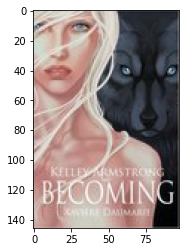

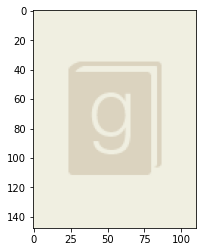

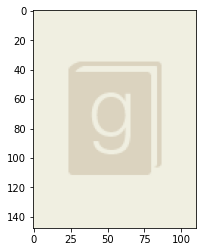

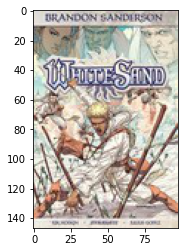

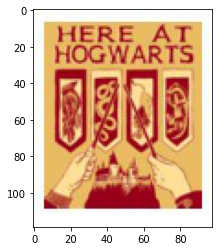

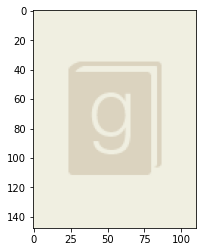

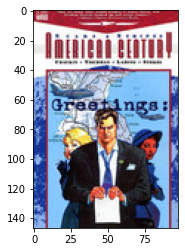

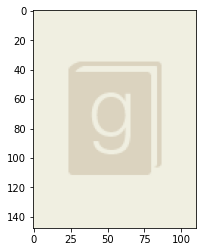

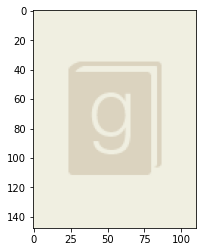

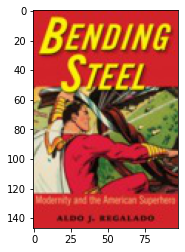

In [40]:
recommended_comics(rec_comic_idx, df_comics)